# Sailboat Classifier

Multi-label classifier for predicting if sailboats have their mainsail, jib, and/or spinnaker hoisted.

Inspired by [Fast AI Fastbook Lesson 1](https://course.fast.ai/Lessons/lesson1.html) and [the reference notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data).

Basic steps:
1. Download and preprocess sailboat photos using Bing
   - In limited testing, Bing appeared to provide better photos than Duck Duck Go. See [01_compare_images_sources.ipynb](https://github.com/sdhca/fastbook_exercises/blob/main/01_compare_image_sources.ipynb)
   
2. Label photos using [Label Studio](https://labelstud.io/) outside this notebook
   - Training images with positive labels will be restricted to only those photos showing a single sailboat.
   
3. Fine-tune a pretrained model

In [ ]:
do_search_and_download = False

# Search & Download Photos

## Bing Search
Note that a [forked version of bing_images](https://github.com/sdhca/bing_images/tree/compatibility_updates) has been used.

In [ ]:
from bing_images import bing

def search_images_with_bing(term, max_images=20, filters=''):
    print(f"Searching for '{term}'")
    return bing.fetch_image_urls(term, limit=max_images, filters=filters)

In [ ]:
%%time
if do_search_and_download:
    urls = search_images_with_bing('sailboat', max_images=500, filters='+filterui:photo')

CPU times: total: 0 ns
Wall time: 0 ns


## Check One Image

In [ ]:
from fastai.vision.all import Image
from urllib.parse import urlparse
from typing import Optional
import requests

def url_to_image(url: str, size: Optional[int]=None) -> Image:
    try:
        im = Image.open(requests.get(url, stream=True).raw)
    except:
        return None
    
    if size is not None:
        (iw, ih) = im.size
        im = im.crop_pad(min(iw, ih))
        im = im.resize((size, size))
        
    im.filename = urlparse(url).path
    
    return im

In [ ]:
if do_search_and_download:
    print(urls[0])
    test_image = url_to_image(urls[0], size=256)
    test_image.to_thumb(256, 256)

## Download All Images

In [ ]:
from fastdownload import download_url
from pathlib import Path
from fastai.vision.utils import download_images

image_path = Path('sailboat_photos')
raw_path = image_path/'raw'
raw_path.mkdir(exist_ok=True, parents=True)
if do_search_and_download:
    download_images(raw_path, urls=urls)

## Preprocess Images
Resize images

In [ ]:
from fastai.vision.utils import resize_images

proc_path = image_path/'preprocessed'
proc_path.mkdir(exist_ok=True, parents=True)

if do_search_and_download:
    resize_images(raw_path, max_size=256, dest=proc_path)

# Label Photos using Label Studio

Photos were labelled in Label Studio using this template:

`<View>
  <Image name="image" value="$image" rotateControl="false"/>
  <Choices name="choice" toName="image" choice="multiple">
    <Choice value="Main"/>
    <Choice value="Jib"/>
    <Choice value="Spinnaker"/>
    <Choice value="Reject Photo"/>
  </Choices>
</View>`

In [ ]:
import pandas as pd

df_labels_raw = pd.read_csv(image_path/'project-4-at-2022-11-14-23-12-b3dd4eaa.csv')
df_labels_raw

,image,id,choice,annotator,annotation_id,created_at,updated_at,lead_time
0,/data/upload/4/f762d119-fffa5987-12a6-4849-8703-63625f41e010.jpg,761,"{""choices"": [""Main"", ""Jib""]}",1,762,2022-11-15T04:11:29.256285Z,2022-11-15T04:11:29.256285Z,1.590
1,/data/upload/4/f44096d4-ff782537-9085-4721-ab0d-f938a5baa1d0.jpeg,760,NaN,1,761,2022-11-15T04:11:27.342191Z,2022-11-15T04:11:27.342191Z,0.866
2,/data/upload/4/51dfc561-ff71fbef-6bf7-4212-9c66-0d65f3978cde.jpg,759,NaN,1,760,2022-11-15T04:11:25.869387Z,2022-11-15T04:11:25.869387Z,0.983
3,/data/upload/4/b53bf771-ff43b12e-1d47-412c-a8cf-286dfe141a01.jpg,758,Reject Photo,1,759,2022-11-15T04:11:24.524713Z,2022-11-15T04:11:24.524713Z,5.051
4,/data/upload/4/0f14b7e8-ff8b9eda-3b61-48d3-b087-f669f93379bf.jpg,757,"{""choices"": [""Main"", ""Jib""]}",1,758,2022-11-15T04:11:18.864808Z,2022-11-15T04:11:18.864808Z,1.152
...,...,...,...,...,...,...,...,...
434,/data/upload/4/cc5a8a00-0ddf520f-be10-4ba5-ae70-f75967a870f9.JPG,327,NaN,1,328,2022-11-15T03:53:53.599265Z,2022-11-15T03:53:53.599265Z,1.147
435,/data/upload/4/a607c40c-0d5a0a76-0ba2-4e53-9e62-4fd78259afbf.jpg,326,"{""choices"": [""Main"", ""Jib""]}",1,327,2022-11-15T03:53:52.050673Z,2022-11-15T03:53:52.050673Z,1.788
436,/data/upload/4/bc7e0ed8-0c9b5cd4-a67b-4184-83c1-146e4d62502a.jpg,325,NaN,1,326,2022-11-15T03:53:49.854320Z,2022-11-15T03:53:49.854320Z,11.494
437,/data/upload/4/84f7334d-0b9abcc7-4ca4-4410-8b1f-75711a313bfa.jpg,324,"{""choices"": [""Main"", ""Jib""]}",1,325,2022-11-15T03:53:37.975283Z,2022-11-15T03:53:37.975283Z,10.618


In [ ]:
df_labels = df_labels_raw[['image', 'choice']].copy()
df_labels['choice'] = df_labels['choice'].replace('\{"choices": \[|]\}|"|,', '', regex=True)
df_labels['choice'] = df_labels['choice'].fillna('')
df_labels = df_labels[df_labels['choice'] != 'Reject Photo']
df_labels['image'] = df_labels['image'].replace('^/data/upload/4/[^-]*-', '', regex=True)


In [ ]:
df_labels

,image,choice
0,fffa5987-12a6-4849-8703-63625f41e010.jpg,Main Jib
1,ff782537-9085-4721-ab0d-f938a5baa1d0.jpeg,
2,ff71fbef-6bf7-4212-9c66-0d65f3978cde.jpg,
4,ff8b9eda-3b61-48d3-b087-f669f93379bf.jpg,Main Jib
5,fea607d8-dbc9-4faa-9f15-46752a806213.jpg,Main Jib
...,...,...
434,0ddf520f-be10-4ba5-ae70-f75967a870f9.JPG,
435,0d5a0a76-0ba2-4e53-9e62-4fd78259afbf.jpg,Main Jib
436,0c9b5cd4-a67b-4184-83c1-146e4d62502a.jpg,
437,0b9abcc7-4ca4-4410-8b1f-75711a313bfa.jpg,Main Jib


In [ ]:
df_labels.groupby('choice').agg('count')

,image
choice,
,93
Jib,3
Main,56
Main Jib,222
Main Jib Spinnaker,12
Main Spinnaker,37
Spinnaker,1


# Train Model

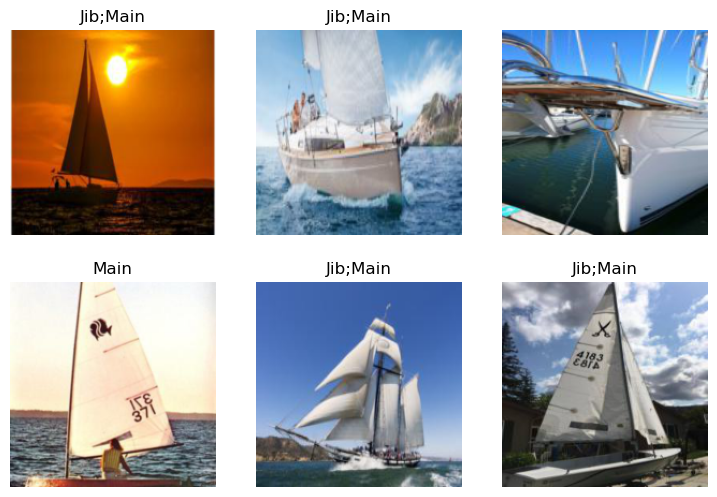

In [ ]:
from fastai.vision.all import DataBlock, ImageBlock, MultiCategoryBlock, ColReader, RandomSplitter, Resize

image_size = 192
batch_size = 512

dls = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader(0, pref=proc_path),
#     get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=ColReader(1, label_delim=' '),
    item_tfms=[Resize(image_size, method='squish')]
).dataloaders(df_labels) #, bs=batch_size)

dls.show_batch(max_n=6)

In [ ]:
%%capture --no-stdout

from fastai.vision.all import vision_learner, resnet18, accuracy_multi
learn = vision_learner(dls, resnet18, metrics=accuracy_multi)

In [ ]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.034017,1.288457,0.460317,00:03


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.726394,0.925547,0.591270,00:02
1,0.610938,0.693603,0.714286,00:01
2,0.518073,0.623779,0.761905,00:01


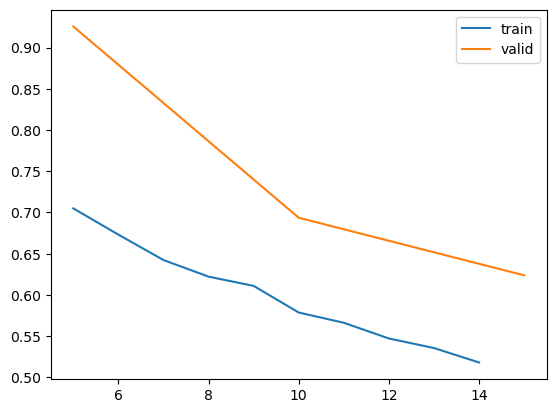

In [ ]:
learn.recorder.plot_loss()